In [11]:
%matplotlib inline

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.extend import primitive, defvjp
from autograd.misc.optimizers import adam
from scipy.special import lambertw as lambertw_
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import autograd.scipy.stats.norm as gnorm

npr.seed(100)

In [12]:
lambertw = primitive(lambda x: lambertw_(x,0).real)
defvjp(lambertw, 
           lambda ans, x: lambda g: g * ans/(x*(1+ans)),
           None 
      )
skewedlambertw = lambda x, skew : lambertw(skew * x)/skew

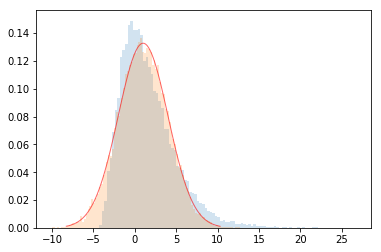

In [13]:
# generate sample data
z = np.random.normal(0.0, 1.0, size = 20000)
loc = 0.
scale = 1.
x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
# plt.plot(x, norm.pdf(x, loc, scale), 'g-', lw=2, alpha=0.02)
# plt.hist(z, 100, normed=True, alpha=0.02)

skew = 0.2
scale = 3
loc = 1

# skew the data with W_\lambda(z) as forward transformation
y = z * np.exp(skew * z) * scale + loc
# unskew the data with $ye^(\lambda y)$ as inverse transformation
z_1 = skewedlambertw((y - loc)/scale, skew) * scale + loc

loc = np.mean(z_1)
scale = np.std(z_1)
x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
plt.plot(x, norm.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6)

plt.hist(y, 100, normed=True, alpha=0.2)
plt.hist(z_1, 100, normed=True, alpha=0.2)
plt.show()

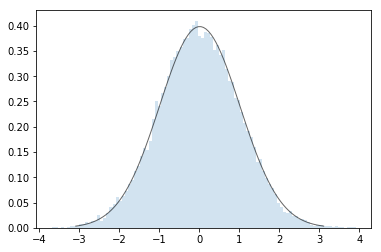

In [14]:
def define_objective(y):
    def objective(params, t):
        loc, log_scale = params[0], params[1]
        return -np.sum(gnorm.logpdf(y, loc, np.exp(log_scale))) 
    return objective

objective = define_objective(z)
gradient = grad(objective)
init_params = np.array([1.,5.])
final_params = adam(gradient, init_params, step_size=0.1, num_iters=500)

loc = final_params[0]
scale = np.exp(final_params[1])
x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
plt.plot(x, norm.pdf(x, loc, scale), 'k-', lw=1, alpha=0.6, label='norm pdf')
plt.hist(z, 100, normed=True, alpha=0.2)
plt.show()

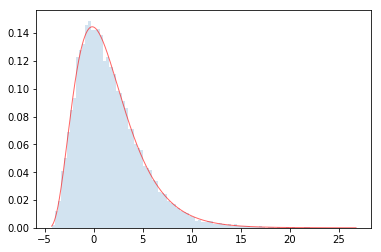

In [15]:
def define_objective(y):
    def objective(params, t):
        loc, log_scale, skew = params[0], params[1], params[2]
        scale = np.exp(log_scale)
        x = (y - loc)/scale
        
        z = skewedlambertw(x, skew)
        
        W = lambertw(x*skew)
        jacobian = W/(skew*x*(1+W))
        return norm.logpdf(z) + np.log(np.abs(jacobian)) - np.log(scale)
    return objective

# objective = define_objective(y)
init_params = np.array([1.,np.log(3), 0.2])
# objective(init_params, 0.)
objective = define_objective(np.sort(y))
plt.plot(np.sort(y), np.exp(objective(init_params, 0)), 'r-', lw=1, alpha=0.6)

# m = skewedlambertw(1, 0.1)
# gradient = grad(objective)
# init_params = np.array([1.,5.])
# final_params = adam(gradient, init_params, step_size=0.1, num_iters=500)

# loc = final_params[0]
# scale = np.exp(final_params[1])
# x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
# plt.plot(x, norm.pdf(x, loc, scale), 'k-', lw=1, alpha=0.6, label='norm pdf')
plt.hist(y, 100, normed=True, alpha=0.2)
# plt.hist(z-2, 100, normed=True, alpha=0.2)

plt.show()

# lambertw(1.0)
# # skewedlambertw(1.0, 0.)
# lambertw(0.2 * 1.0)/0.2
# gradient = grad(skewedlambertw, 0)

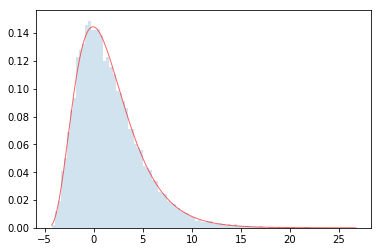

In [74]:
def unpack_params(params):
    return params[0], params[1], params[2]
#     return 1., np.log(3.), params[0]

def lambertw_logpdf(y, params):
    loc, log_scale, skew_ = unpack_params(params)
    scale = np.exp(log_scale)
    skew = 0.2/(1+np.exp(-skew_))
    u = (y - loc)/scale
    u_ = u*skew
    W = lambertw(u_)
    z = W/skew
    jacobian = W/(u_*(1+W))
    return norm.logpdf(z) + np.log(np.abs(jacobian)) - log_scale

def define_objective(y):
    def objective(params, t):
        loc, log_scale, skew_ = unpack_params(params)
        scale = np.exp(log_scale)
        skew = 0.2/(1+np.exp(-skew_))
        u = (y - loc)/scale
        u_ = u*skew
        W = lambertw(u_)
        z = W/skew
        jacobian = W/(u_*(1+W))
        return -(np.sum(gnorm.logpdf(z) + np.log(np.abs(jacobian)) - log_scale))
    return objective

init_params = np.array([0.,np.log(10),0])
objective = define_objective(y)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.01, num_iters=1000)

plt.plot(np.sort(y), np.exp(lambertw_logpdf(np.sort(y), final_params)), 'r-', lw=1, alpha=0.6)
plt.hist(y, 100, normed=True, alpha=0.2)
plt.show()

In [64]:
0.2/(1+np.exp(-10000))

0.20000000000000001